Running test case 0 with input '[[[1, -0.333333], [-0.333333, 1]], [0.48063554, 0.87692045]]'...
Eigen values =  [1.333333 0.666667] [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Exp(1j Hermitian)
[1, 2] [3]
1 [0, 1] 3.141592653589793
2 [1, 0] 1.0471975511965976
Eigen values =  [1.333333 0.666667] [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Exp(1j Hermitian)
[1, 2] [3]
1 [0, 1] 3.141592653589793
2 [1, 0] 1.0471975511965976
HHL output  [0.61625253 0.78754861]
Correct!
Running test case 1 with input '[[[0.456, -0.123], [-0.123, 0.123]], [0.96549299, 0.26042903]]'...
Eigen values =  [0.49650543 0.08249457] [[ 0.9498228  0.3127885]
 [-0.3127885  0.9498228]]
Exp(1j Hermitian)
[1, 2] [3]
1 [0, 1] 3.141592653589793
2 [1, 0] 1.0471975511965976
Eigen values =  [0.49650543 0.08249457] [[ 0.9498228  0.3127885]
 [-0.3127885  0.9498228]]
Exp(1j Hermitian)
[1, 2] [3]
1 [0, 1] 3.141592653589793
2 [1, 0] 1.0471975511965976
HHL output  [0.92650762 0.37627599]


AssertionError: 

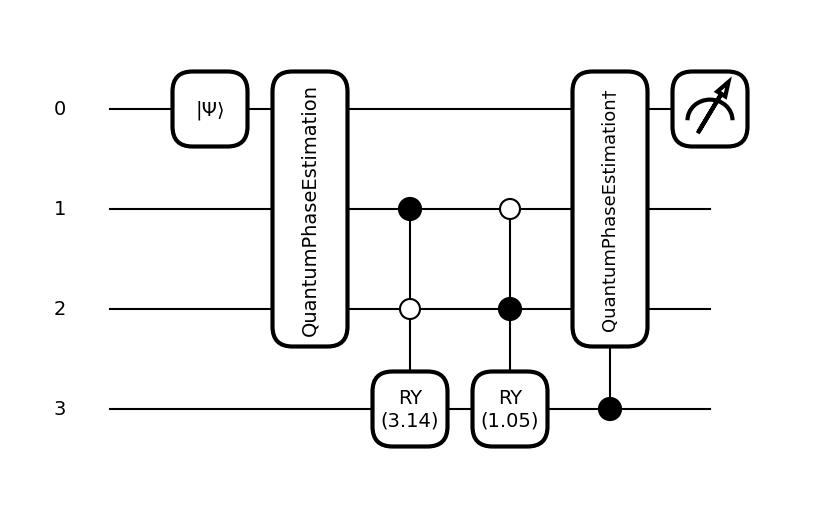

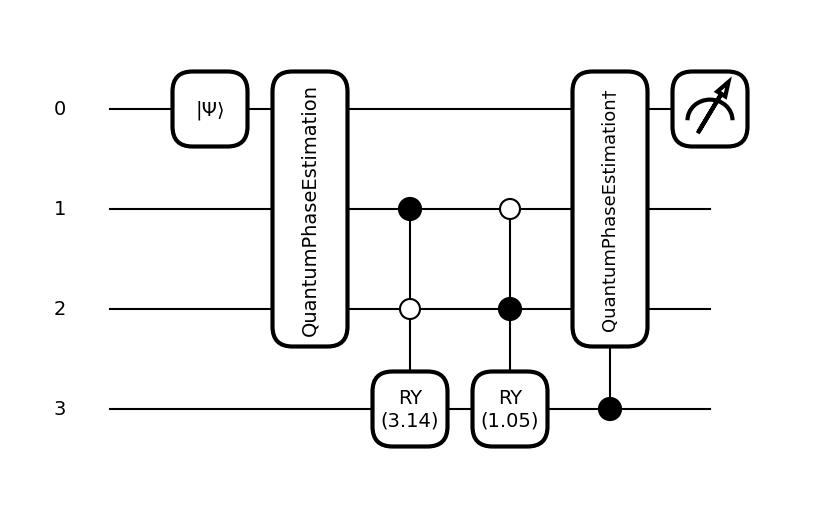

In [5]:
import json
import pennylane as qml
import pennylane.numpy as np




# Put any helper functions here that you want to make #


def encode_hermitian(A, wires):
    """
    Encodes a hermitian matrix A as a unitary U = e^{iA}.

    Args
        - A (numpy.tensor): a 2x2 matrix
        - b (numpy.tensor): a length-2 vector

    Returns
        - (qml.Operation): a unitary operation U = e^{iA}
    """
    return qml.exp(qml.Hermitian(A, wires=wires), coeff=1j)


def mint_to_lime(A, b):
    """
    Calculates the optimal mint and lime proportions in the Mojito HHLime twist.

    Args
        - A (numpy.tensor): a 2x2 matrix
        - b (numpy.tensor): a length-2 vector

    Returns
        - x (numpy.tensor): the solution to Ax = b
        (int): the number of operations in your HHL circuit.
    """
    b_qubits = 1
    b_wires = [0]

    qpe_qubits = 2
    qpe_wires = list(range(b_qubits, b_qubits + qpe_qubits))

    ancilla_qubits = 1
    ancilla_wires = list(
        range(b_qubits + qpe_qubits, ancilla_qubits + b_qubits + qpe_qubits)
    )

    all_wires = b_wires + qpe_wires + ancilla_wires
    dev = qml.device("default.qubit", wires=all_wires)

    @qml.qnode(dev)
    def HHL(A, b):
        evalues, evectors = np.linalg.eig(A)
        print ('Eigen values = ', evalues, evectors)
        qml.AmplitudeEmbedding(b, wires=b_wires)
        U = encode_hermitian(A, b_wires)
        print (U)
        qml.QuantumPhaseEstimation(U, estimation_wires=qpe_wires,) 
        print (qpe_wires, ancilla_wires)
        # qml.SWAP(wires=[1,2])
        for i in [1, 2]:
            cv = [int(i) for i in format(i, '04b')[2:]]
            print (i, cv, 2*np.arcsin(1/i))
            qml.ctrl(qml.RY, qpe_wires, control_values=cv[::-1])(2*np.arcsin(1/i), wires=ancilla_wires)
        # qml.ctrl(qml.RY, qpe_wires, control_values=[1,0,1,0,1,0,1,0,1,0])(2*np.arcsin(1/682), wires=ancilla_wires)
        def reversed(wires):
            qml.adjoint(qml.QuantumPhaseEstimation)(U, estimation_wires=qpe_wires)

        qml.ctrl(reversed, control=ancilla_wires, control_values="0")(wires=ancilla_wires)

              
        return qml.probs(wires=b_wires)
        # return qml.state()
    # we return probs, but we need the state itself (it will be real-valued)
    x = np.sqrt(HHL(A, b))
    qml.draw_mpl(HHL, decimals=2, expansion_strategy="gradient")(A, b)
    print ("HHL output ", x)
    return x, len(HHL.tape._ops)


# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:
    A, b = json.loads(test_case_input)
    output, num_ops = mint_to_lime(np.array(A), np.array(b))
    output = output.tolist()
    output.append(num_ops)
    return str(output)


def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    output = solution_output[:-1]
    num_ops = solution_output[-1]
    expected_output = json.loads(expected_output)

    assert num_ops > 4, "Your circuit should have a few more operations!"
    assert np.allclose(output, expected_output, rtol=1e-2)


# These are the public test cases
test_cases = [
    ('[[[1, -0.333333], [-0.333333, 1]], [0.48063554, 0.87692045]]', '[0.6123100731658992, 0.7906177169127275]'),
    ('[[[0.456, -0.123], [-0.123, 0.123]], [0.96549299, 0.26042903]]', '[0.5090526763759141, 0.8607353673888718]'),
]

# This will run the public test cases locally
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")